In [6]:
library(mclust)
library(cluster)
library(Rtsne)
library(uwot)
library(umap)
library(DESeq2)
library(amap)
library(tidyverse)
library(magrittr)
library("apeglm")
library("pheatmap")
library(Hobotnica)
library(pbapply)
library(reticulate)
library(limma)

In [7]:
count_matrix<- read.delim("C:\\Users\\Ermias\\Documents\\data visualization\\R_project\\GSE80333.countmatrix.txt",
                          row.names = 1,sep = ",")
anno<- read.delim("C:\\Users\\Ermias\\Documents\\data visualization\\R_project\\SraRunTable_GSE80333.pam50.txt",
                  row.names = 1,sep = ",")

In [8]:
count_matrix<-count_matrix[,rownames(anno)] 
rownames(anno) <- colnames(count_matrix) 

In [9]:
dds <-DESeqDataSetFromMatrix(countData = count_matrix,
                             colData = anno,
                             design = ~ group)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



In [10]:
dds

class: DESeqDataSet 
dim: 11625 10 
metadata(1): version
assays(1): counts
rownames(11625): A1CF A2ML1 ... ZYX ZZZ3
rowData names(0):
colnames(10): MCF7_separate_culture MCF7_co.culture ...
  SUM149PT_separate_culture SUM149PT_co.culture
colData names(1): group

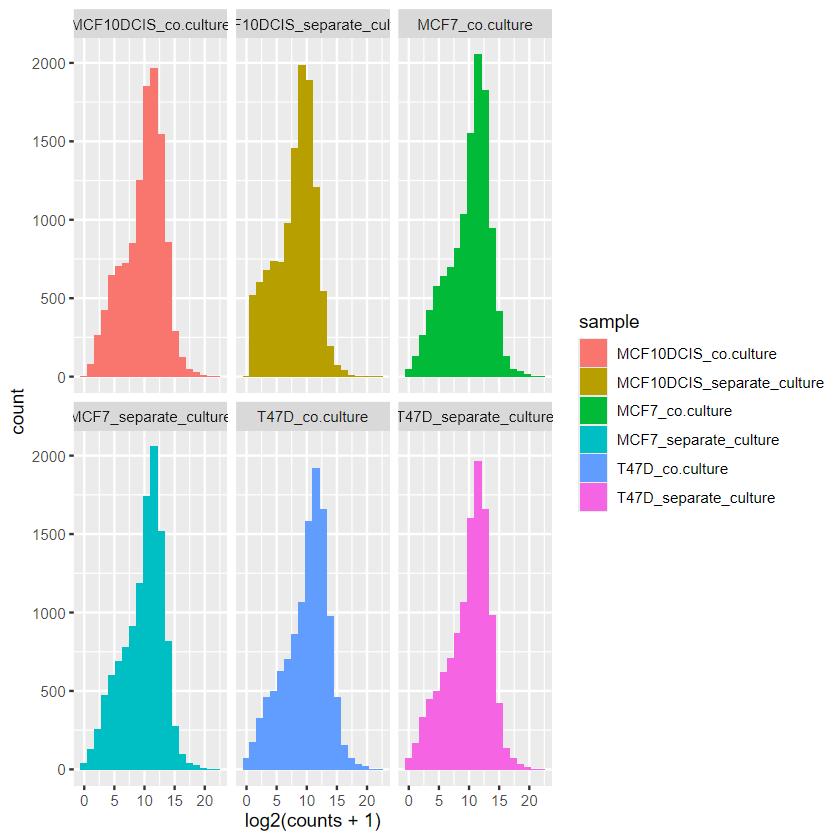

In [11]:
as_tibble(assay(dds), rownames = "Group") %>%
  pivot_longer(names_to = "sample", values_to = "counts", cols = 2:7) %>% 
  ggplot(aes(x = log2(counts + 1), fill = sample)) +
  geom_histogram(bins = 20) +
  facet_wrap(~ sample)

In [12]:
dds <- dds[rowSums(assay(dds)) > 0,]
dim(dds)

[1] 11625    10

In [13]:
dds <- DESeq(dds)

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing



In [14]:
vsd <- vst(dds, blind = TRUE)

using ntop=500 top features by variance



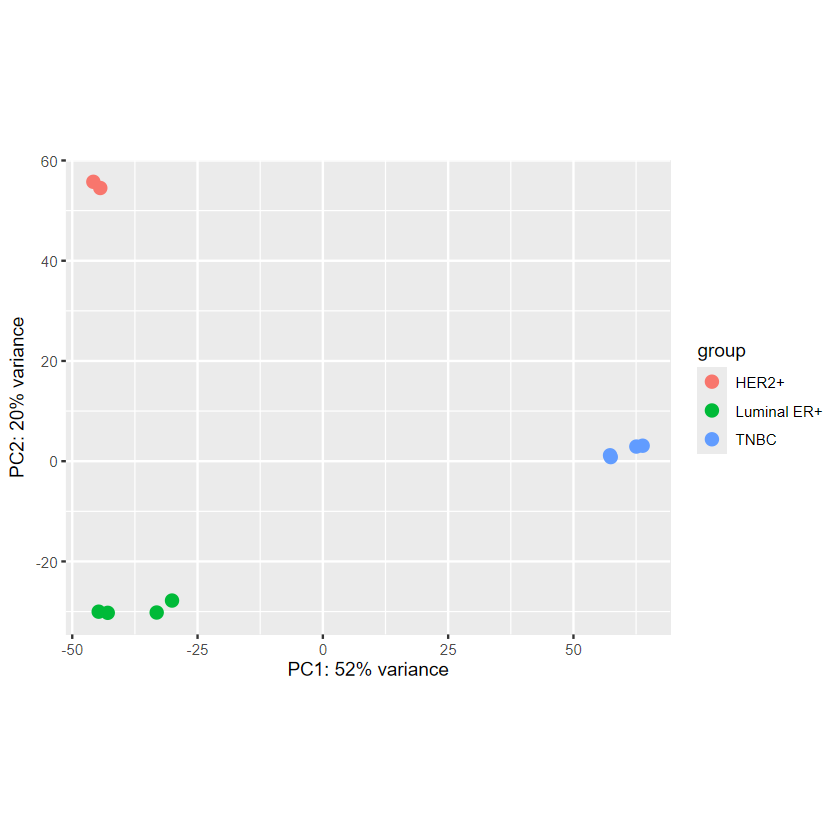

In [15]:
plotPCA(vsd,intgroup="group")

In [16]:
colnames(colData(vsd))

[1] "group"      "sizeFactor"

In [17]:
pca_data <- plotPCA(vsd,intgroup="group",returnData=TRUE)

using ntop=500 top features by variance



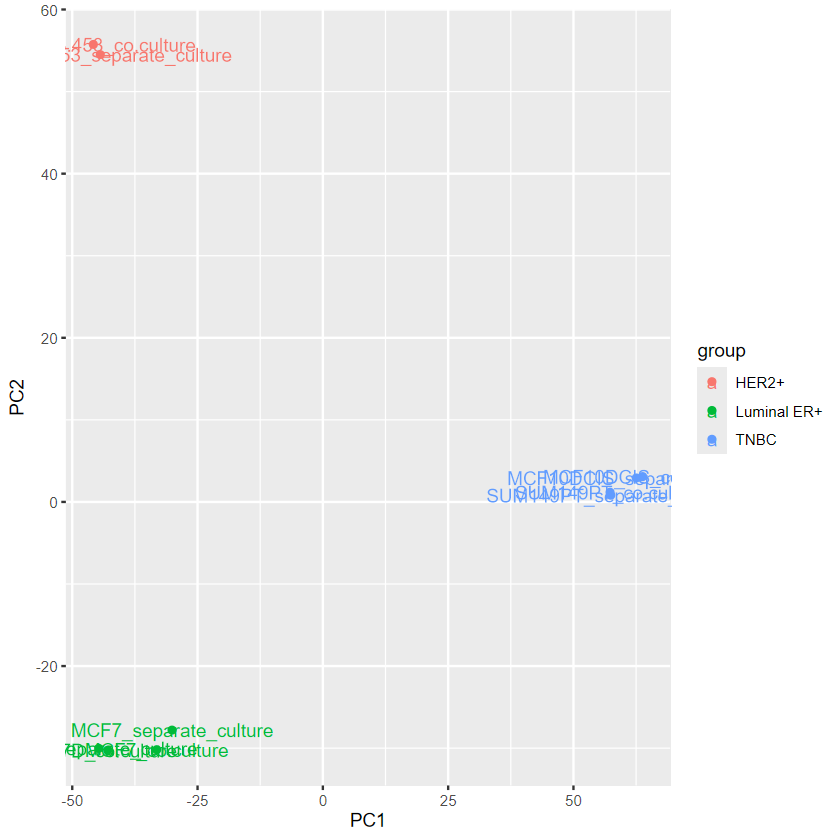

In [18]:
ggplot(pca_data,aes(x = PC1 , y= PC2,color = group,label = name))+
  geom_point()+
  geom_text()

In [19]:
sizeFactors(dds)

MCF7_separate_culture             MCF7_co.culture 
                  1.3501165                   1.7212306 
      T47D_separate_culture             T47D_co.culture 
                  1.5948662                   1.6110339 
 MCF10DCIS_separate_culture        MCF10DCIS_co.culture 
                  0.4261327                   1.3804715 
MDA.MB.453_separate_culture       MDA.MB.453_co.culture 
                  0.8481372                   0.6666945 
  SUM149PT_separate_culture         SUM149PT_co.culture 
                  0.8986348                   0.5956503

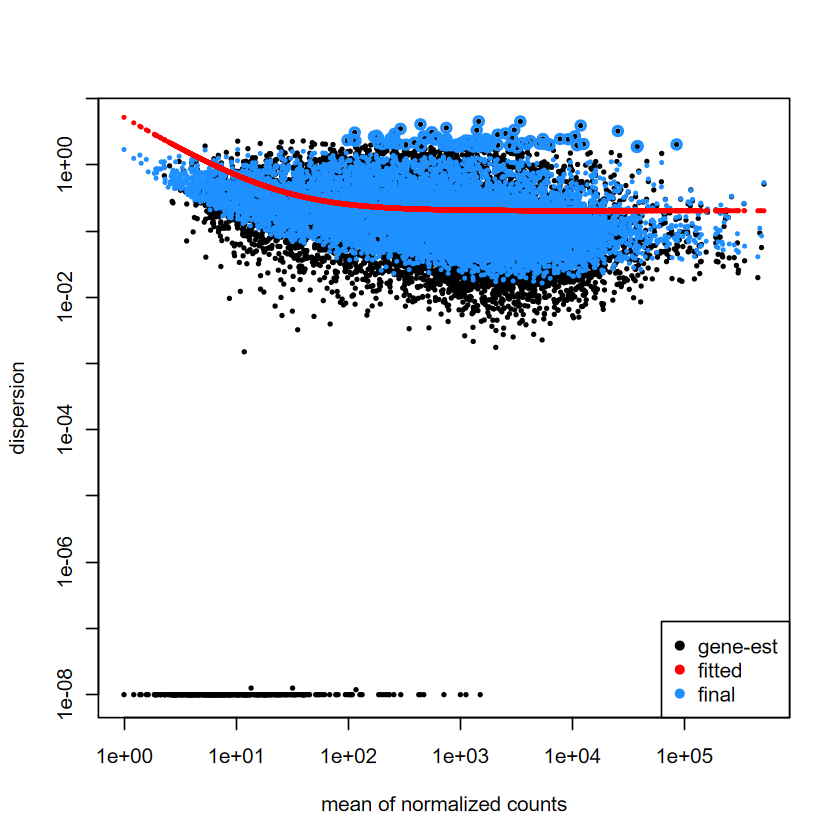

In [20]:
plotDispEsts(dds)

In [21]:
resultsNames(dds)

[1] "Intercept"                  "group_Luminal.ER._vs_HER2."
[3] "group_TNBC_vs_HER2."

In [22]:
dds$group

[1] Luminal ER+ Luminal ER+ Luminal ER+ Luminal ER+ TNBC        TNBC       
 [7] HER2+       HER2+       TNBC        TNBC       
Levels: HER2+ Luminal ER+ TNBC

In [23]:
levels(dds$group)

[1] "HER2+"       "Luminal ER+" "TNBC"

In [24]:
dds$group <- relevel(dds$group, ref = "HER2+")
dds <- DESeq(dds)
resultsNames(dds)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing



[1] "Intercept"                  "group_Luminal.ER._vs_HER2."
[3] "group_TNBC_vs_HER2."

In [25]:
dds$group <- factor(dds$group)    # ensure factor
levels(dds$group)


[1] "HER2+"       "Luminal ER+" "TNBC"

In [26]:
res <- results(dds, 
                name = "group_Luminal.ER._vs_HER2.")

In [27]:
res <- results(dds, contrast=c("group", "HER2+", "Luminal ER+"))

In [28]:
res_tbl <- as_tibble(res, rownames = "ENSEMBL")
res_tbl

ENSEMBL,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1CF,69.95066,0.3546439,0.4924149,0.7202137,4.713934e-01,0.6065947326
A2ML1,2194.90441,0.9570336,0.2848225,3.3601055,7.791272e-04,0.0039545473
AAAS,2434.84894,1.1843909,0.4040606,2.9312207,3.376329e-03,0.0131795982
AACS,230.09827,0.9552369,0.4633646,2.0615235,3.925313e-02,0.0934494803
AACSP1,33.00491,0.9034990,0.9798732,0.9220571,3.564988e-01,0.4971803464
AADAC,12.25039,-0.1183684,0.6867938,-0.1723492,8.631630e-01,0.9130908805
AADACL3,9.29994,1.2246718,0.7144351,1.7141822,8.649527e-02,0.1732441561
AADAT,856.68577,-1.9928319,1.1785330,-1.6909428,9.084773e-02,0.1797911788
AAGAB,2995.00637,0.3711723,0.3799046,0.9770145,3.285620e-01,0.4689185341


In [29]:
res_tbl %>%
  arrange(padj) %>%
  head(20)

ENSEMBL,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NRK,1460.5854,7.842713,0.3814124,20.56229,5.974595e-94,6.938298e-90
GPX1,23410.8160,9.287875,0.4657624,19.94123,1.786147e-88,1.037126e-84
ACN9,1515.0966,7.844426,0.4528646,17.32179,3.221637e-67,1.247096e-63
PTPLA,1107.3167,-4.404755,0.2558626,-17.21531,2.038402e-66,5.917990e-63
TMTC1,1334.7233,5.554833,0.3250348,17.08997,1.762771e-65,4.094211e-62
IFI27,9771.3900,-8.374859,0.5152184,-16.25497,2.059715e-59,3.986578e-56
C2orf74,1982.7259,-4.900710,0.3016874,-16.24433,2.449969e-59,4.064499e-56
NGFRAP1,25512.5946,-7.036837,0.4567054,-15.40782,1.450131e-53,2.105046e-50
PDLIM1,3402.8602,-7.314299,0.4797471,-15.24616,1.746153e-52,2.253119e-49


In [30]:
top20_genes <- res_tbl %>% arrange(padj) %>% head(20) %>% pull(ENSEMBL)
top20_expr <- count_matrix[top20_genes, ]
dist_top20 <- amap::Dist(t(top20_expr), method = "kendall")
h_score_result <- Hobotnica(dist_top20, anno$group)
h_score_result
str(h_score_result)

[1] 1

 num 1


In [32]:
randomSignaturesList <- vector("list",1000)
all_genes <- rownames(count_matrix)
sig_length <- 40  # Since you want 40 genes in each subsample

if (length(all_genes) < sig_length) {
  stop(paste("Insufficient genes for random sampling. Available:", length(all_genes), "Needed:", sig_length))
}

for (i in 1:1000) {
  randomSignaturesList[[i]] <- sample(all_genes, sig_length)
}

randomSigScores <- pbsapply(randomSignaturesList, function(gset) {
  submat <- count_matrix[gset, , drop=FALSE]
  distMatrix <- as.matrix(Dist(t(submat), method="kendall", nbproc=40))
  Hobotnica(distMatrix, anno$group)
})
str(randomSigScores)

 num [1:1000] 0.903 0.802 0.977 0.983 0.697 ...


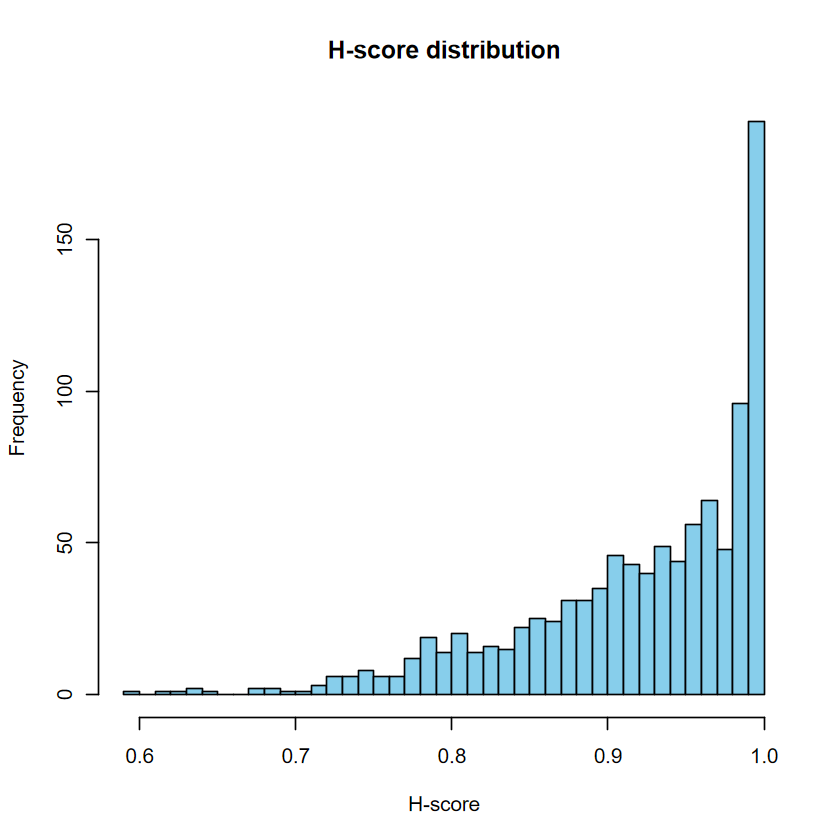

In [33]:
hist(randomSigScores, breaks = 50, main = "H-score distribution", xlab = "H-score", col = "skyblue")

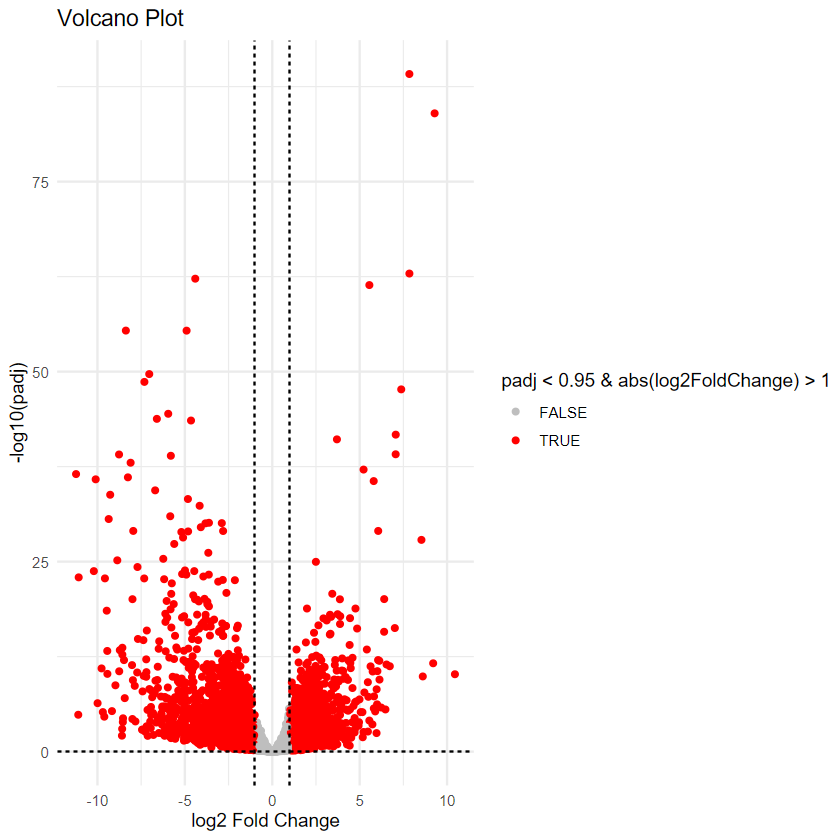

In [34]:
res_tbl %>%
  filter(!is.na(padj)) %>%
  ggplot(aes(x = log2FoldChange, y = -log10(padj))) +
  geom_point(aes(color = padj < 0.95 & abs(log2FoldChange) > 1), size = 1.2) +
  scale_color_manual(values = c("grey", "red")) +
  geom_hline(yintercept = -log10(0.95), linetype = "dashed") +
  geom_vline(xintercept = c(-1, 1), linetype = "dashed") +
  labs(title = "Volcano Plot", x = "log2 Fold Change", y = "-log10(padj)") +
  theme_minimal()

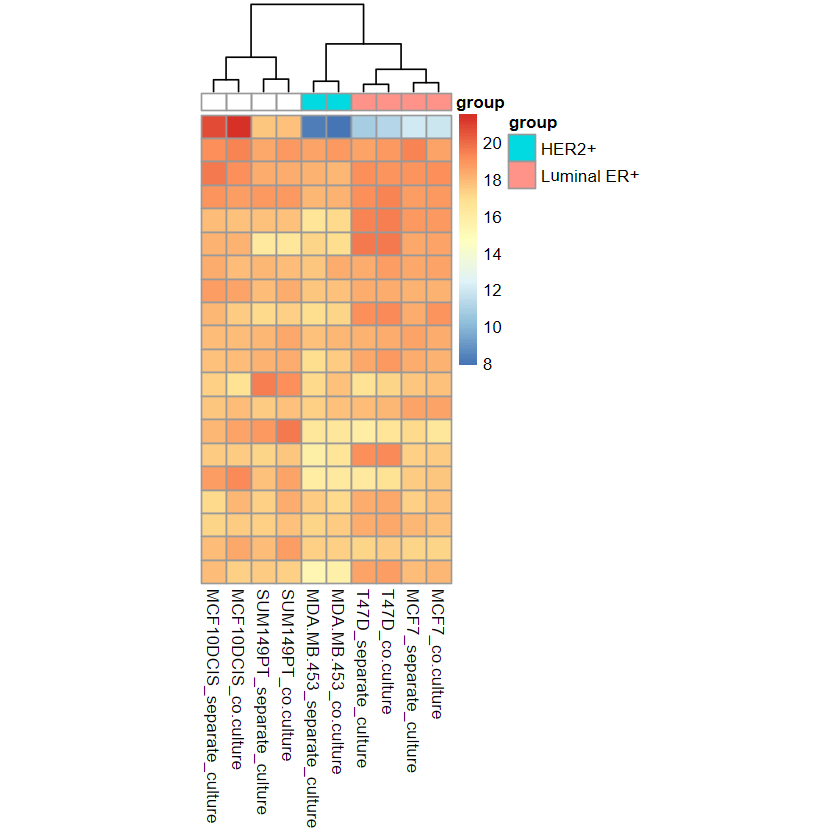

In [35]:
df <- as.data.frame(colData(dds)[, "group",drop=FALSE])
df <- df[df$group %in% c("HER2+", "Luminal ER+"),,drop=FALSE]
vsd_sub <- vsd[, rownames(df)]
select <- order(rowMeans(counts(dds, normalized=TRUE)), decreasing=TRUE)[1:20]
pheatmap(assay(vsd)[select,], 
         cluster_rows=FALSE, 
         show_rownames=FALSE,
         cluster_cols=TRUE, 
         annotation_col=df,
         cellwidth = 15)

[1] FALSE


      HER2+ Luminal ER+        TNBC 
          2           4           4 

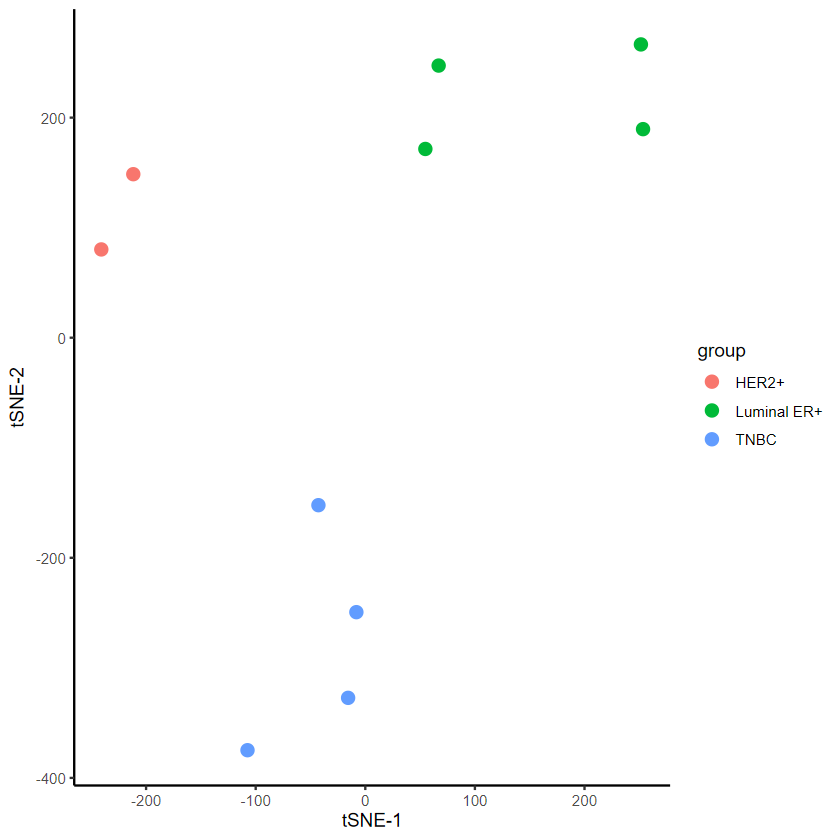

In [36]:
data <- log2(t(count_matrix) + 1)
data_clean <- data[complete.cases(data), ]
anyNA(data_clean)  # should return FALSE

group <- anno$group[match(rownames(data_clean), rownames(anno))]
group <- factor(group)  # convert to factor to avoid NA issues

# Run t-SNE
set.seed(10)
tsne_results <- Rtsne(data_clean,
                      perplexity = 3,
                      eta = 1000,
                      max_iter = 5000)

# Create a data.frame for plotting
Y <- as.data.frame(tsne_results$Y)
colnames(Y) <- c("tSNE1", "tSNE2")
Y$group <- group  

# Check for NA in Group
table(Y$group)

# Plot
library(ggplot2)
ggplot(Y, aes(x = tSNE1, y = tSNE2, color = group)) +
  geom_point(size = 3) +
  labs(x = "tSNE-1", y = "tSNE-2", color = "group") +
  theme_classic()

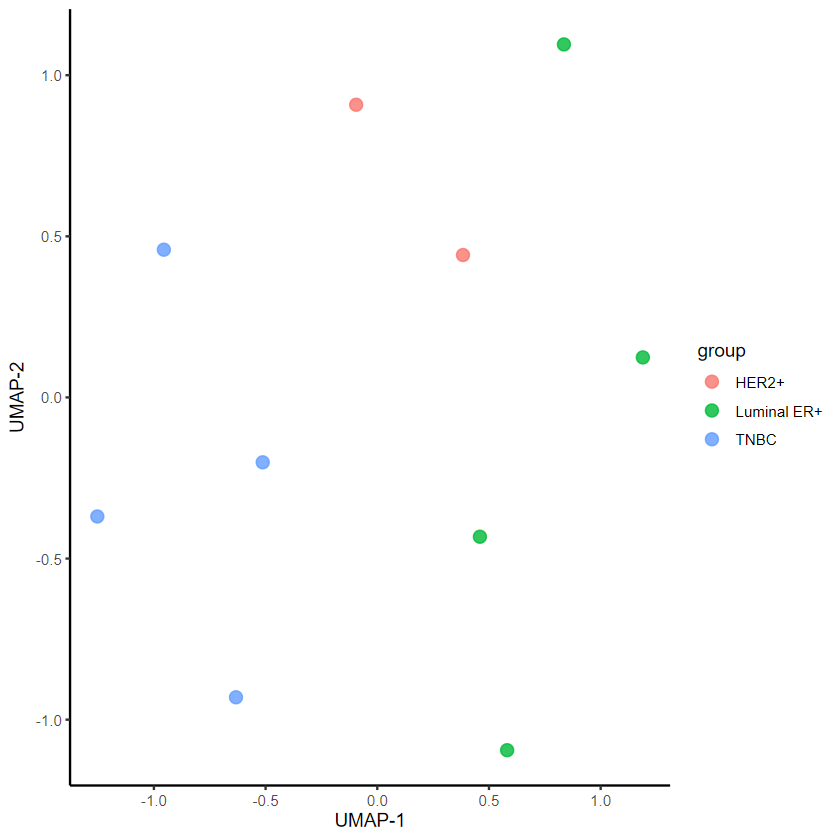

In [37]:
mat <- assay(vsd)
var_genes <- head(order(rowVars(mat), decreasing = TRUE), 2000)
mat_var <- mat[var_genes, , drop = FALSE]
pca <- prcomp(t(mat_var), scale. = TRUE)
npcs <- min(30, ncol(pca$x))
nsamp <- nrow(pca$x)
nneigh <- min(15, nsamp - 1)

emb <- uwot::umap(pca$x[, 1:npcs, drop = FALSE],
                  n_neighbors = nneigh,
                  min_dist = 0.1)

umap_df <- data.frame(UMAP1 = emb[,1], UMAP2 = emb[,2],
                      sample = rownames(pca$x))
meta <- as.data.frame(colData(vsd))
umap_df$group <- meta[umap_df$sample, "group", drop = TRUE]

# 5) plot
ggplot(umap_df, aes(UMAP1, UMAP2, color = group)) +
  geom_point(size = 3, alpha = 0.8) +
  labs(x = "UMAP-1", y = "UMAP-2", color = "group") +
  theme_classic()




In [38]:
expr_t <- t(top20_expr)
group <- anno$group[match(rownames(expr_t), rownames(anno))]
stopifnot(length(group) == nrow(expr_t))

k <- length(unique(group))

# --- PCA ---
pca_embed <- prcomp(expr_t, scale. = TRUE)$x[, 1:2]

# --- UMAP 
set.seed(123)
n_neighbors <- min(15, nrow(expr_t) - 1)
umap_result <- umap::umap(expr_t, n_neighbors = n_neighbors)
umap_embed <- umap_result$layout

# --- t-SNE 
set.seed(123)
perpl <- min(3, nrow(expr_t) - 1)
tsne_embed <- Rtsne(expr_t, dims = 2, perplexity = perpl)$Y

# --- Clustering ---
km_pca  <- kmeans(pca_embed, centers = k)$cluster
km_umap <- kmeans(umap_embed, centers = k)$cluster
km_tsne <- kmeans(tsne_embed, centers = k)$cluster

# --- Metrics: Silhouette + ARI ---
sil_pca  <- mean(silhouette(km_pca,  dist(pca_embed))[, 3])
sil_umap <- mean(silhouette(km_umap, dist(umap_embed))[, 3])
sil_tsne <- mean(silhouette(km_tsne, dist(tsne_embed))[, 3])

ari_pca  <- adjustedRandIndex(km_pca,  group)
ari_umap <- adjustedRandIndex(km_umap, group)
ari_tsne <- adjustedRandIndex(km_tsne, group)

# --- Hobotnica Score ---
dist_top20 <- amap::Dist(t(top20_expr), method = "kendall")
h_score_result <- Hobotnica(dist_top20, group)

# --- Score Summary Table ---
score_df <- data.frame(
  Method = c("PCA", "UMAP", "t-SNE", "Hobotnica"),
  Silhouette = c(sil_pca, sil_umap, sil_tsne, NA),
  ARI = c(ari_pca, ari_umap, ari_tsne, NA)
)

print(score_df)


     Method Silhouette       ARI
1       PCA  0.7505350 1.0000000
2      UMAP  0.4331401 0.7232472
3     t-SNE  0.5389013 0.4660194
4 Hobotnica         NA        NA


In [39]:
randomSignaturesList <- vector("list", 1000)
all_genes <- rownames(count_matrix)
sig_length <- 40 
if (length(all_genes) < sig_length) {
  stop(paste("Insufficient genes for random sampling. Available:", length(all_genes), "Needed:", sig_length))
}

for (i in 1:1000) {
  randomSignaturesList[[i]] <- sample(all_genes, sig_length)
}

label_vector <- as.integer(factor(anno$group))

compute_metrics <- function(gset) {
  submat <- count_matrix[gset, , drop = FALSE]
  
  if (anyNA(submat)) return(rep(NA, 3))
  
  distMatrix <- as.matrix(Dist(t(submat), method = "kendall", nbproc = 40))
  #H_score
  hob_score <- Hobotnica(distMatrix, anno$group)
  
  # Silhouette score
  pam_clustering <- tryCatch({
    pam_res <- pam(distMatrix, k = length(unique(label_vector)))
    sil_score <- mean(silhouette(pam_res$clustering, distMatrix)[, 3])
    sil_score
  }, error = function(e) NA)
  
  # ARI
  ari_score <- tryCatch({
    pam_res <- pam(distMatrix, k = length(unique(label_vector)))
    adjustedRandIndex(pam_res$clustering, label_vector)
  }, error = function(e) NA)

  return(c(hob_score, sil_score, ari_score))
}

randomMetrics <- pbsapply(randomSignaturesList, compute_metrics)

randomMetrics_df <- as.data.frame(t(randomMetrics))
colnames(randomMetrics_df) <- c("H_score", "Silhouette", "ARI")

head(randomMetrics_df)

,H_score,Silhouette,ARI
,<dbl>,<dbl>,<dbl>
1,0.9663462,0.5285181,0.5673077
2,0.9711538,0.4315268,1.0000000
3,0.9735577,0.3520374,0.7232472
4,0.9531250,0.4810614,0.5673077
5,0.9951923,0.5271295,1.0000000
6,0.9939904,0.4471798,1.0000000


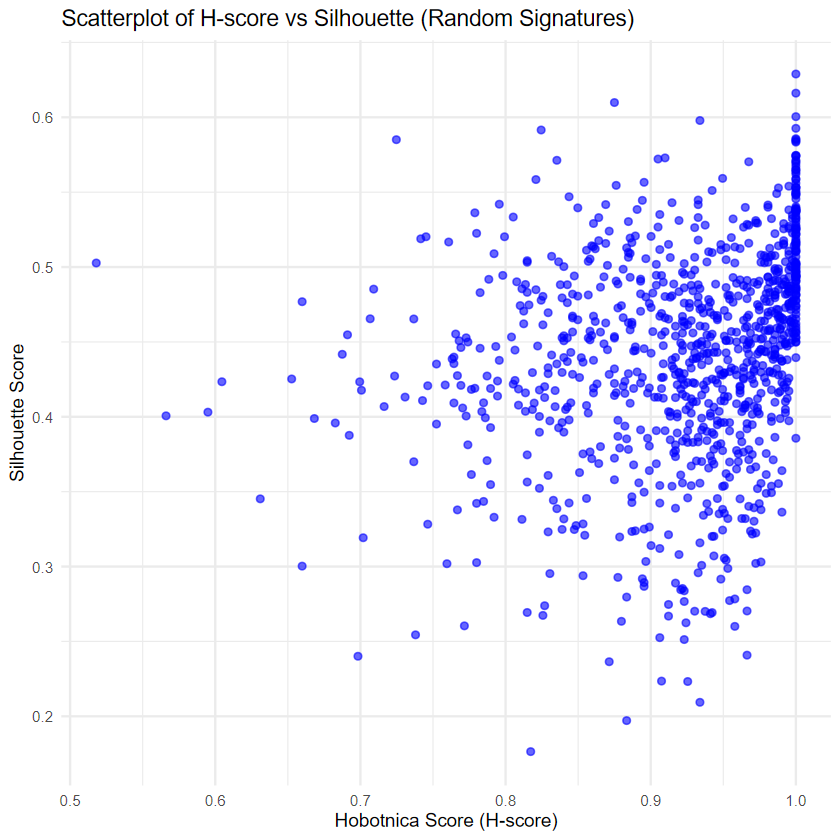

In [40]:
ggplot(randomMetrics_df, aes(x = H_score, y = Silhouette)) +
  geom_point(alpha = 0.6, color = "blue") +
  theme_minimal() +
  labs(title = "Scatterplot of H-score vs Silhouette (Random Signatures)",
       x = "Hobotnica Score (H-score)",
       y = "Silhouette Score")

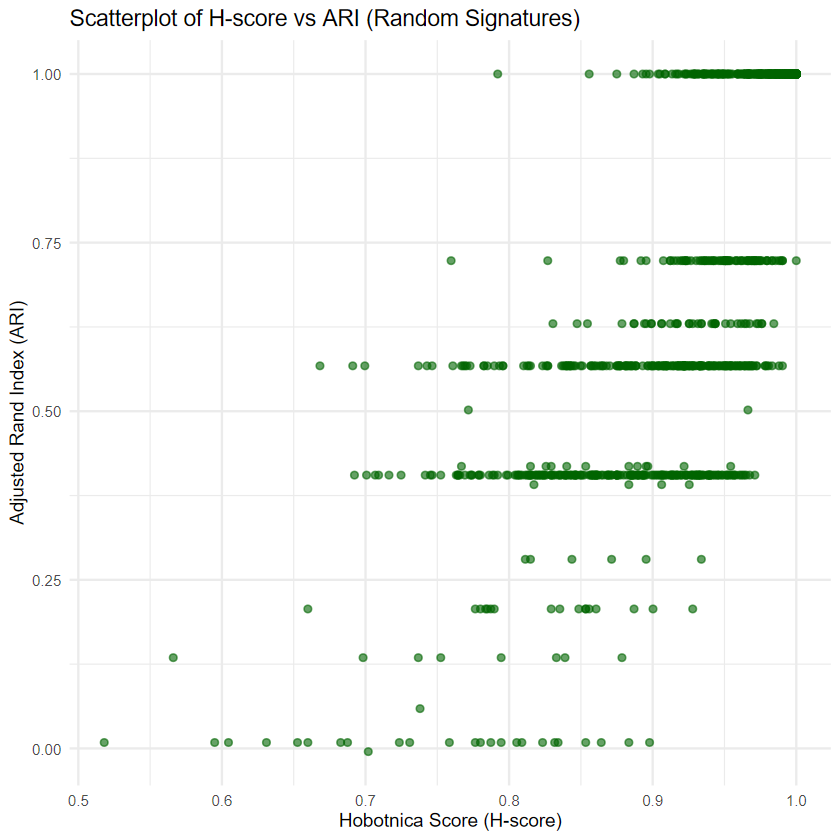

In [41]:
ggplot(randomMetrics_df, aes(x = H_score, y = ARI)) +
  geom_point(alpha = 0.6, color = "darkgreen") +
  theme_minimal() +
  labs(title = "Scatterplot of H-score vs ARI (Random Signatures)",
       x = "Hobotnica Score (H-score)",
       y = "Adjusted Rand Index (ARI)")